# Analysis of within-list blocks

The sample dataset includes miniblocks within each list, ranging from length 2 to 6. Here, we'll demonstrate how columns can be added to the data to analyze these miniblocks.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import importlib

module_path = '/Users/morton/PycharmProjects/psifr'
if module_path not in sys.path:
    sys.path.append(module_path)
from psifr import fr
data_file = os.path.join(module_path, 'data', 'cfr_raw_data.csv')

In [2]:
df = pd.read_csv(data_file, dtype={'category': 'category'})
df.category.cat.as_ordered(inplace=True)

First, split the data into study and recall events. We'll later merge these events together to make a unified data table.

In [3]:
study = df.query('trial_type == "study"').copy()
recall = df.query('trial_type == "recall"').copy()

For some advanced analyses, we'll analyze based on the block structure in the data. This requires adding two columns: the block index and the maximum number of blocks in each list.

In [4]:
# add label to study events indicating the block
list_category = study.groupby(['subject', 'list'])['category']
study.loc[:, 'block'] = list_category.transform(fr.block_index)

# get the number of blocks for each study list
n_block = study.groupby(['subject', 'list'])['block'].max()
n_block.name = 'n_block'

# merge the n_block field
study = pd.merge(study, n_block, left_on=['subject', 'list'], 
                 right_on=['subject', 'list'], how='outer')

We'll also look at position within block. This requires two more columns: block position and block length.

In [5]:
study.loc[:, 'block_pos'] = study.groupby(['subject', 'list', 'block'])['position'].cumcount() + 1
block_len = study.groupby(['subject', 'list', 'block'])['block_pos'].max()
block_len.name = 'block_len'
study = pd.merge(study, block_len, left_on=['subject', 'list', 'block'],
                 right_on=['subject', 'list', 'block'], how='outer')

Display one list to check our new block-related columns.

In [6]:
study.loc[(study['subject'] == 1) & (study['list'] == 2)]

,subject,list,position,trial_type,item,session,list_type,category,response,response_time,block,n_block,block_pos,block_len
24,1,2,1,study,SEAN PENN,1,mixed,cel,3.0,1.255,1,6,1,2
25,1,2,2,study,AUDREY HEPBURN,1,mixed,cel,3.0,1.040,1,6,2,2
26,1,2,3,study,ST PATRICKS CATHEDRAL,1,mixed,loc,2.0,1.164,2,6,1,4
27,1,2,4,study,LES INVALIDES,1,mixed,loc,2.0,0.829,2,6,2,4
28,1,2,5,study,GREAT ZIMBABWE RUINS,1,mixed,loc,3.0,0.872,2,6,3,4
29,1,2,6,study,BRYCE CANYON,1,mixed,loc,2.0,1.241,2,6,4,4
30,1,2,7,study,TROPHY,1,mixed,obj,3.0,0.862,3,6,1,2
31,1,2,8,study,BRUSH,1,mixed,obj,3.0,0.779,3,6,2,2
32,1,2,9,study,SUPREME COURT,1,mixed,loc,2.0,1.245,4,6,1,4
33,1,2,10,study,SAN FRANCISCO,1,mixed,loc,4.0,0.854,4,6,2,4


In [7]:
# list_keys: columns to include for both study and recall events
# study_keys: columns to include for study events only
data = fr.merge_lists(study, recall, list_keys=['list_type'], 
                      study_keys=['category', 'block', 'n_block', 'block_pos', 'block_len'])
clean = data.query('repeat == 0 and ~intrusion')

### Recall by block

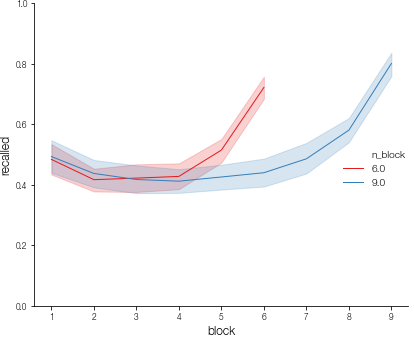

In [8]:
# block only really applies to mixed lists
mixed = clean.loc[clean['list_type'] == 'mixed']

# get recall by block, separated by the number of blocks in each list
rec = mixed.groupby(['subject', 'list_type', 'n_block', 'block'])['recalled'].mean()
g = sns.relplot(kind='line', x='block', y='recalled', palette=sns.color_palette('Set1', 2),
                hue='n_block', data=rec.reset_index());
g.set(ylim=(0, 1));

### Recall by position within block

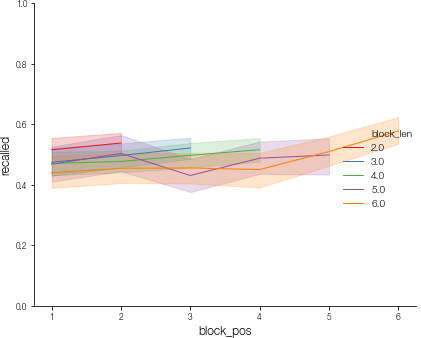

In [9]:
rec = mixed.groupby(['subject', 'list_type', 'block_len', 'block_pos'])['recalled'].mean()
g = sns.relplot(kind='line', x='block_pos', y='recalled', palette=sns.color_palette('Set1', 5),
                hue='block_len', data=rec.reset_index());
g.set(ylim=(0, 1));